## 3) Modelisation 1 (Entrainement et Test)

L'objectif de cette phase est de sélectionner et d'entraîner des algorithmes d'apprentissage automatique pour répondre à la problématique centrale : 

### Rappel de la problématique 

*Comment modéliser et prédire efficacement les prix des produits Dior de
Chine, et quels sont les facteurs déterminants qui influencent le pricing dans le secteur du luxe ?*

### Séparation et Préparation

In [28]:
# Import
import sys
import os

sys.path.append(os.path.abspath("../src"))
from preprocessing import preprocess_dior
from modelisation import (
    split_data,
    plot_train_test_split,
    transform_target,
    plot_target_transformation,
    ohe_encoding,
    count_encoding,
    target_encoding,
    train_model
)
from evaluate import(
    evaluate_model,
    plot_actual_vs_predicted,
    plot_residuals_distribution,
    plot_residuals_vs_predicted,
    plot_learning_curve,
    plot_correlation_matrix,
    plot_prediction_curve
)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from load_data import load_dior
# chargement du dataset
df = load_dior()

In [3]:
X, y = preprocess_dior(df)

# X -> title + categories
# y -> price et price_eur

In [4]:
X.head()

,category1_code,category2_code,category3_code
0,WOMEN,SMALL LEATHER GOODS,MINI BAGS
1,WOMEN,SMALL LEATHER GOODS,POUCHES
2,WOMEN,MAISON,DECORATIVE PIECES
3,WOMEN,HANDBAGS,HANDBAGS
4,TIMEPIECES,EXCEPTIONAL TIMEPIECES,DIOR GRANDBAL


In [5]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

Shape X_train : (3580, 3)
Shape X_test  : (896, 3)
Shape y_train : (3580, 1)
Shape y_test  : (896, 1)


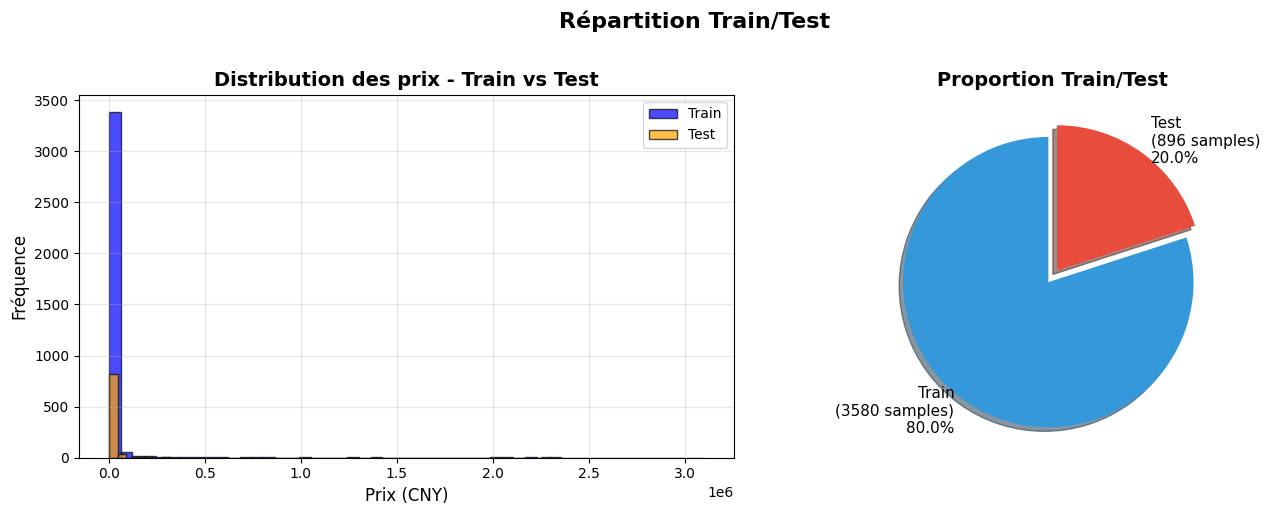

In [6]:
plot_train_test_split(y_train, y_test)

### Standardisation, Normalisation, Log

In [7]:
y_train_transformed, y_test_transformed, transform_info = transform_target(
    y_train, 
    y_test, 
    method='log'
)

Transformation: log(1 + prix)


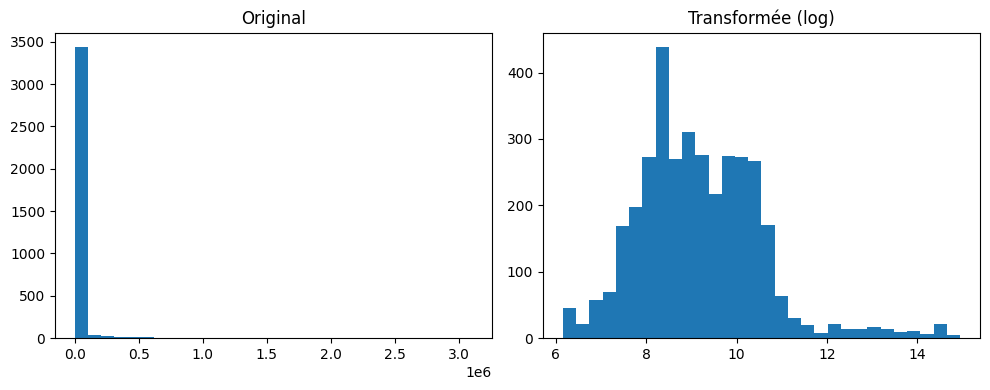

,price
2032,11.884496
4287,10.373522
1790,7.741099
1196,9.711176
696,8.594339
...,...
4448,8.716208
469,7.741099
3109,9.928229
3792,8.556606


In [8]:
plot_target_transformation(y_train, 'log')

### Encodage et transformation

In [9]:
# Application du encoding sur Category1, 2 et 3_code.

X_train_encoder, X_test_encoder, enc1 = ohe_encoding(X_train, X_test, "category1_code")

In [10]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train_encoder, X_test_encoder, "category2_code")

In [11]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train_encoder, X_test_encoder, "category3_code")

In [12]:
# target_encoding

In [13]:
print(X_train_encoder.columns[:20])

Index(['category1_code_BABY DIOR', 'category1_code_JEWELLERY',
       'category1_code_MEN', 'category1_code_TIMEPIECES',
       'category1_code_WOMEN', 'category2_code_count', 'category3_code_count'],
      dtype='object')


In [14]:
print(X_train_encoder.shape)
print(X_test_encoder.shape)

(3580, 7)
(896, 7)


### Entrainement, Test, Prediction

**Choix du modèle : Random Forest**

Pour prédire le prix des produits Dior China, nous avons choisi **Random Forest**.  
Ce modèle est non linéaire et basé sur un ensemble d’arbres de décision, ce qui permet de capturer des relations complexes entre les caractéristiques et le prix. Il est robuste aux outliers et fonctionne bien avec des variables catégorielles encodées (OHE ou count/frequency). Chaque arbre prédit un prix, et la prédiction finale est obtenue en moyennant les prédictions de tous les arbres.

$$
\hat{y} = \frac{1}{B} \sum_{b=1}^{B} \hat{f}_b(x)
$$

où :  
- $\hat{y}$ : valeur prédite par la forêt  
- $B$ : nombre d’arbres dans la forêt  
- $\hat{f}_b(x)$ : prédiction du $b$-ième arbre pour l’échantillon $x$

Random Forest réduit la variance par rapport à un arbre unique et permet d’identifier l’importance relative des variables dans la prédiction.


In [15]:
# Model de Random Forest 
from sklearn.ensemble import RandomForestRegressor

In [25]:
model_LR = RandomForestRegressor(oob_score=True)

# Training 
model_LR_trained = train_model(
    model_LR, 
    X_train_encoder, 
    y_train_transformed, 
    X_test_encoder, 
    y_test_transformed
)

C:\Users\poowd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [26]:
model_LR_trained.oob_score_

0.85149671740864

In [ ]:
# Prédictions sur le train
y_train_pred_log = model_LR_trained.predict(X_train_encoder)

# Inverse log transform
y_train_pred = np.expm1(y_train_pred_log)

# Calcul des métriques
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("TRAIN RMSE :", rmse_train)
print("TRAIN MAE  :", mae_train)
print("TRAIN R²   :", r2_train)

TRAIN RMSE : 91266.63358582174
TRAIN MAE  : 18253.57051093645
TRAIN R²   : 0.8172842058732213


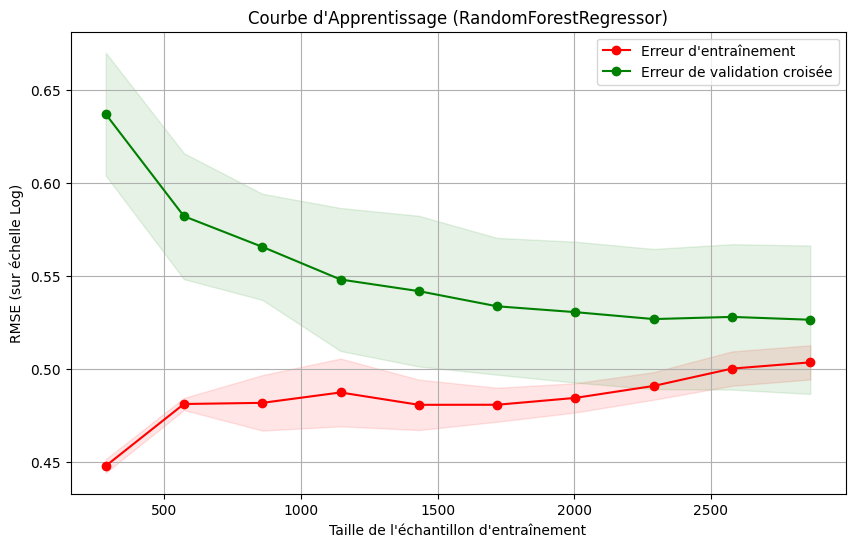

In [18]:
plot_learning_curve(model_LR, X_train_encoder, y_train_transformed)

In [ ]:
evaluation_results = evaluate_model(
    model=model_LR_trained,
    X_test_encoder=X_test_encoder,
    y_test_raw=y_test  
)

print("\n Résumé des Performances")
print(f"Modèle : {evaluation_results['model_name']}")
print(f"RMSE : {evaluation_results['rmse']:,.2f}")
print(f"MAE  : {evaluation_results['mae']:,.2f}")
print(f"R²   : {evaluation_results['r2']:.4f}")


--- Résumé des Performances ---
Modèle : RandomForestRegressor
RMSE : 90,045.92
MAE  : 18,062.48
R²   : 0.8019


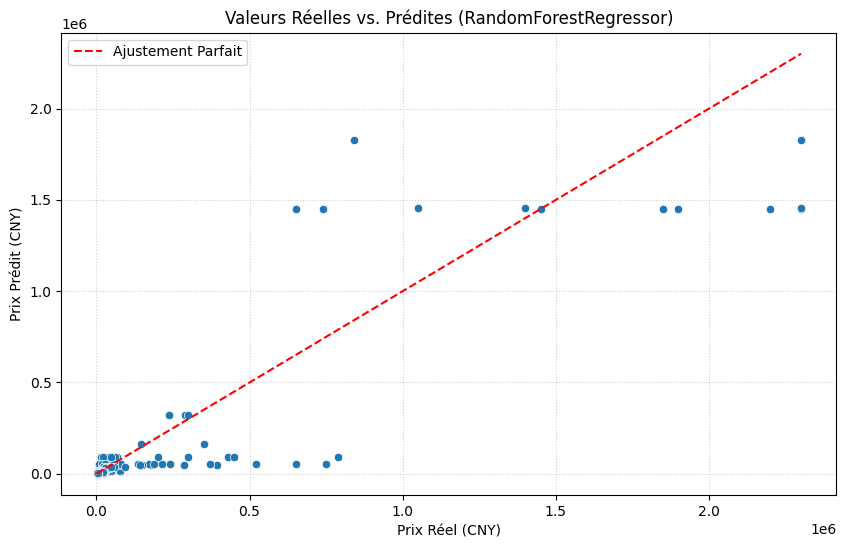

In [20]:
plot_actual_vs_predicted(y_test, evaluation_results['y_pred_original'], evaluation_results['model_name'])

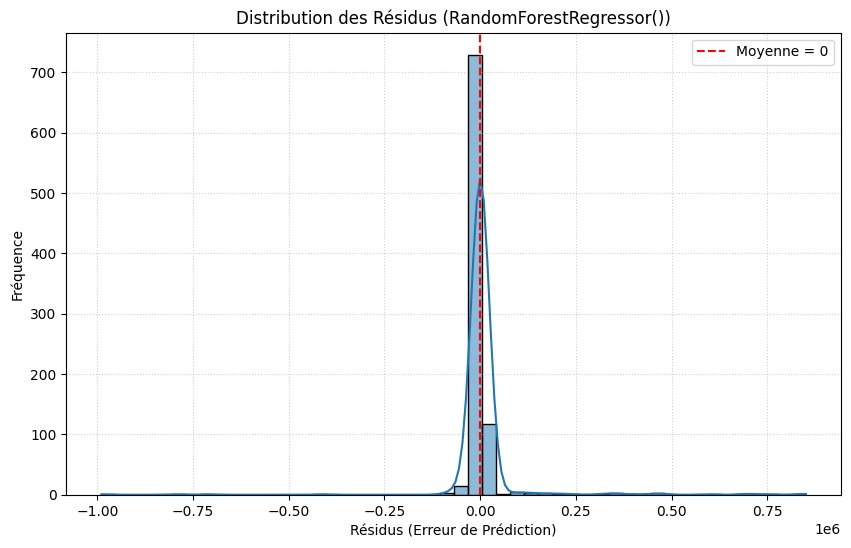

In [21]:
plot_residuals_distribution(y_test, evaluation_results['y_pred_original'], model_LR_trained)

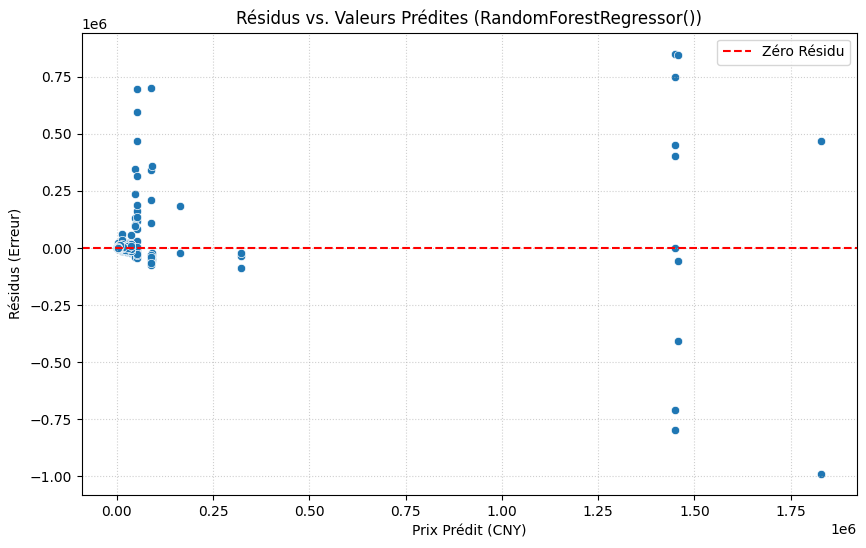

In [22]:
plot_residuals_vs_predicted(evaluation_results['y_pred_original'], y_test, model_LR_trained)

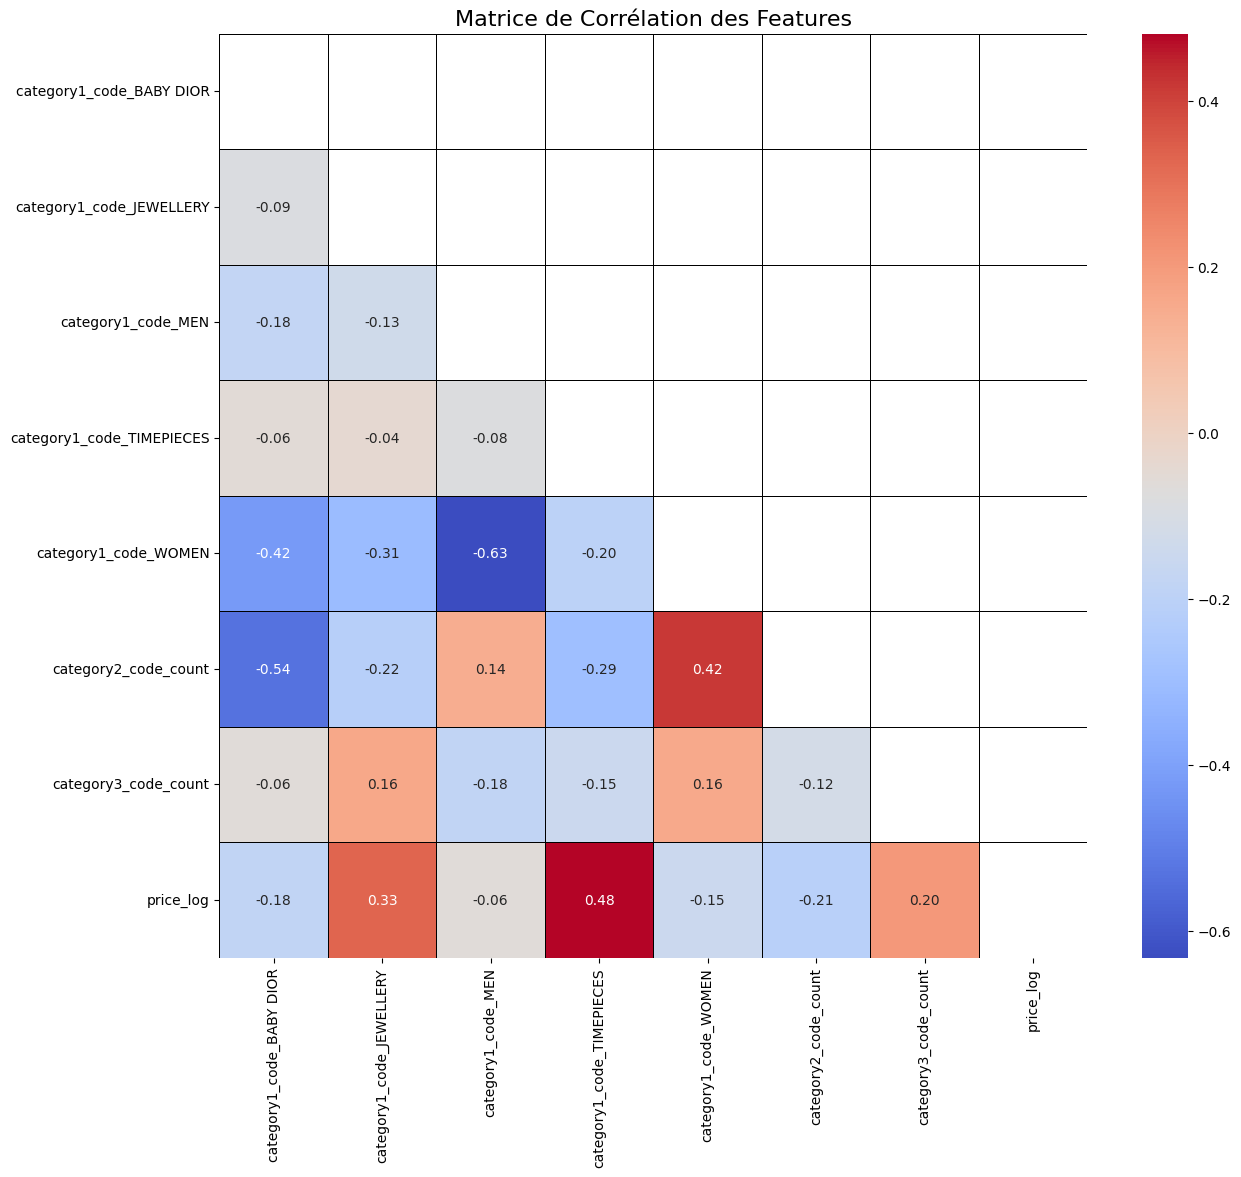

In [23]:
plot_correlation_matrix(X_train_encoder, y_train_transformed)

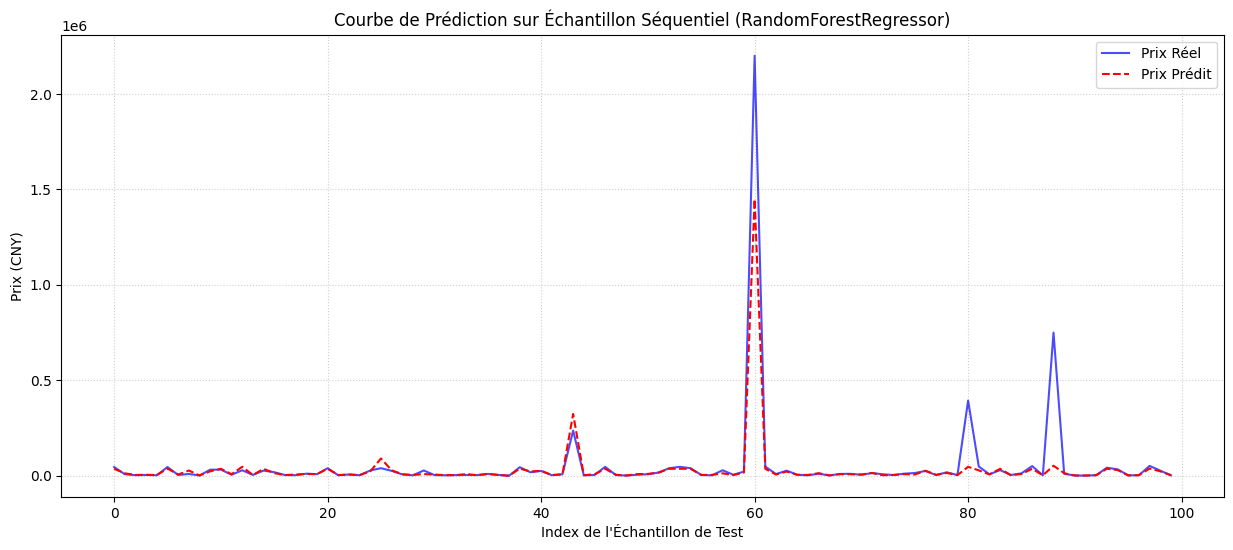

In [24]:
plot_prediction_curve(y_test, evaluation_results["y_pred_original"], evaluation_results["model_name"], sample_size=100)